In [396]:
%%time
import glob
import joblib
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import altair as alt
from collections import Counter
import re
import json

extracted_data = joblib.load("../data/ru_wiki_extracted_pages.data")
error_data = joblib.load("../data/ru_wiki_error_pages.data")
final_data = pd.DataFrame(joblib.load("../data/ru_wiki_final_dataset_v2.data"))
with open('../data/ru_reveal_wiki_location.json') as user_file:
    ru_reveal_wiki_location = json.load(user_file)
locations_dict = dict()
for location in tqdm(ru_reveal_wiki_location):
    location_key = list(location.keys())[0]
    location_values = np.sort(list(location.values())[0])
    locations_dict[location_key] = "_".join(location_values)

  0%|          | 0/1035086 [00:00<?, ?it/s]

CPU times: user 1min 12s, sys: 38.6 s, total: 1min 51s
Wall time: 2min 6s


In [4]:
def clean_text(text):
    if text is None:
        return text
    # Remove \n characters
    text = re.sub(r'\n', ' ', text)
    # Remove redundant spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def clean_template(text):
    return text

def get_template_parameters(templates):
    all_parameters = {}
    for t in templates:
        # Split the template string on the '|' character
        parts = t.split('|')

        if parts:
            # The first part is assumed to be the template name
            template_name = parts[0]

            # Initialize a dictionary for the current template
            template_parameters = {}

            # Process the remaining parts as parameter key-value pairs
            for param_pair in parts[1:]:
                param_split = param_pair.split('=')
                param_name, param_value = param_split[0], "".join(param_split[1:])
                # Create a combined key using the template name and parameter name
                combined_key = f"{template_name}+{param_name}"
                template_parameters[clean_text(combined_key)] = clean_text(param_value)

            # Add the template name and its parameters to the dictionary
            all_parameters.update(template_parameters)

    return all_parameters


def compare_templates(t1, t2): 
    params1 = get_template_parameters([t1])
    params2 = get_template_parameters([t2])
    changes = []
    for i in params1.keys():
        if params2.get(i) != params1.get(i):
            param_to_add = (i, params1.get(i), params2.get(i))
            if param_to_add not in changes:
                changes.append(param_to_add)
                
    for i in params2.keys():
        if params2.get(i) != params1.get(i):
            param_to_add = (i, params1.get(i), params2.get(i))
            if param_to_add not in changes:
                changes.append(param_to_add)
    
    return changes

In [6]:
from fuzzywuzzy import fuzz  # type: ignore
from itertools import product

changed_df = final_data[final_data.status.isin([4])].reset_index(drop=True)

locations = changed_df.page_name.apply(lambda d: locations_dict.get(d, "unknown")).reset_index(drop=True)
changed_df["location"] = locations

# Category
categories_added, categories_removed, common_cat = [], [], []
categories_counter, common_categories_counter = Counter(), Counter()
for wiki_features, ruwiki_features in \
    zip(changed_df["wiki_features"].to_list(), changed_df["ruwiki_features"].to_list()):
    categories_added.append(set(ruwiki_features["categories"]) - set(wiki_features["categories"]))
    categories_removed.append(set(wiki_features["categories"]) - set(ruwiki_features["categories"]))
    common_cat.append(set(wiki_features["categories"]) & set(ruwiki_features["categories"]))
    categories_counter.update(categories_added[-1])
    categories_counter.update(categories_removed[-1])
    common_categories_counter.update(common_cat[-1])

changed_df["categories_removed"] = categories_removed
changed_df["categories_added"] = categories_added

# Templates
tem_added, tem_deleted, param_change = [], [], []
tem_added_counter, tem_deleted_counter, param_change_counter = Counter(), Counter(), Counter()
for wiki_features, ruwiki_features in \
    tqdm(zip(changed_df["wiki_features"].to_list(), changed_df["ruwiki_features"].to_list())):
    tem_added.append(list(set([clean_template(i) for i in ruwiki_features["templates"]]) - set([clean_template(i) for i in wiki_features["templates"]]) - set([None])))
    tem_deleted.append(list(set([clean_template(i) for i in wiki_features["templates"]]) - set([clean_template(i) for i in ruwiki_features["templates"]]) - set([None])))
    tem_added_counter.update(tem_added[-1])
    tem_deleted_counter.update(tem_deleted[-1])
    
    params_changed = []
    
    tem_added_tmp = set(ruwiki_features["templates"]) - set(wiki_features["templates"]) - set([None])
    tem_deleted_tmp = set(wiki_features["templates"]) - set(ruwiki_features["templates"]) - set([None])
    for t1, t2 in product(tem_added_tmp, tem_deleted_tmp):
        similarity = fuzz.ratio(t1, t2)
        if similarity > 60 and similarity < 100:
            try:
                tem_added[-1].remove(t1)
            except:
                pass
            try:
                tem_deleted[-1].remove(t2)
            except:
                pass
            
            try:
                params_changed += compare_templates(t1, t2)
            except:
                print(t1)
                pass
    param_change.append(params_changed)
    param_change_counter.update(params_changed)
    

changed_df["tem_added"] = tem_added

In [7]:
changed_df

,page_name,status,lines_added,lines_deleted,lines_changed,actions,wiki_features,ruwiki_features,parsing_time,location,categories_removed,categories_added
0,Железнодорожный (Нижегородская область),4,[Проводной интернет предоставлен операторами Р...,[Кабельное телевидение предоставлено операторо...,"[(В посёлке имеются детский сад, школа, нескол...","{'change_Argument': 0, 'insert_Argument': 0, '...",{'categories': ['Населённые пункты городского ...,{'categories': ['Населённые пункты городского ...,2023-09-28 20:57:57.783308,Russia,{},{}
1,Улица Чкалова (Мелитополь),4,[],[Улица Чкалова (укр],[(Вулиця Чкалова) — улица на севере Мелитополя...,"{'change_Argument': 0, 'insert_Argument': 0, '...","{'categories': ['Улицы Мелитополя'], 'media': ...","{'categories': ['Улицы Мелитополя'], 'media': ...",2023-09-28 20:57:57.870430,Ukraine,{},{}
2,Моленар,4,[],"[Моленар, Брам (род]",[(1961) — активный член сообщества Open Source...,"{'change_Argument': 0, 'insert_Argument': 0, '...","{'categories': [], 'media': [], 'references': ...","{'categories': [], 'media': [], 'references': ...",2023-09-28 20:57:57.992658,unknown,{},{}
3,"Чтак, Валерий Сергеевич",4,[],[],"[(2015 — «Доброе утро, иностранцы», Галерея «T...","{'change_Argument': 0, 'insert_Argument': 0, '...",{'categories': ['Современные художники России'...,{'categories': ['Современные художники России'...,2023-09-28 20:57:58.063718,unknown,{},{}
4,GSMA,4,[],[],[(Megafon PSSC (Мегафон) (Компания была исключ...,"{'change_Argument': 0, 'insert_Argument': 0, '...","{'categories': ['GSM', 'Международные ассоциац...","{'categories': ['GSM', 'Международные ассоциац...",2023-09-28 20:57:58.108138,unknown,{},{}
...,...,...,...,...,...,...,...,...,...,...,...,...
18515,"Каноков, Арсен Баширович",4,[16 декабря 2022 года включён в санкционный сп...,"[16 декабря 2022 года, на фоне вторжения Росси...","[(Из-за вторжения России на Украину, находится...","{'change_Argument': 0, 'insert_Argument': 0, '...","{'categories': ['Главы Кабардино-Балкарии', 'Ч...","{'categories': ['Главы Кабардино-Балкарии', 'Ч...",2023-09-29 00:26:36.128824,Russia,"{Лица, подвергнутые санкциям в связи с конфлик...",{}
18516,Марихуана,4,[],[Курение марихуаны],[],"{'change_Argument': 0, 'insert_Argument': 0, '...","{'categories': ['Препараты из конопли', 'Психо...","{'categories': ['Препараты из конопли', 'Психо...",2023-09-29 00:26:36.303812,unknown,{},{}
18517,История административно-территориального делен...,4,[],[],[(По состоянию на 2022 год административно-тер...,"{'change_Argument': 0, 'insert_Argument': 0, '...",{'categories': ['История административно-терри...,{'categories': ['История административно-терри...,2023-09-29 00:26:49.454812,unknown,{},{}
18518,Катунь,4,[У юго-западных окраин города Бийска сливается...,"[Площадь бассейна — 60 900 км², Длина реки — 6...",[],"{'change_Argument': 0, 'insert_Argument': 0, '...","{'categories': ['Катунь', 'Притоки Оби', 'Реки...","{'categories': ['Катунь', 'Притоки Оби', 'Реки...",2023-09-29 00:26:49.534632,Russia,{},{}


In [9]:
texts_to_embed = []
for title, added, deleted, changed, loc, cat_add, cat_rem, tem_add in zip(
    changed_df.page_name, changed_df.lines_added, changed_df.lines_deleted, 
    changed_df.lines_changed, changed_df.location, changed_df.categories_removed,
    changed_df.categories_added, changed_df.tem_added):
    
    text = f"""Page title: {title}"""
    if loc and loc!="unknown":
        text += f"\nPage location: {loc}"
    if len(changed) > 0:
        text += f"\nLines changed (| separated pairs of text before and after): {'|'.join([str(a) for a in changed[:25] if len(a) < 400])}"
    if len(deleted) > 0:
        text += f"\nLines deleted (| separated): {'|'.join([a for a in deleted[:25] if len(a) < 200])}"
    if len(added) > 0:
        text += f"\nLines added (| separated): {'|'.join([a for a in added[:25] if len(a) < 200])}"
    if len(tem_add) > 0:
        text += f"\nTemplates added (| separated): {'|'.join([a for a in tem_add[:25] if len(a) < 100])}"
    if len(cat_rem) > 0:
        text += f"\nCategories removed (| separated): {'|'.join(list(cat_rem)[:20])}"
    if len(cat_add) > 0:
        text += f"\nCategories added (| separated): {'|'.join(list(cat_add)[:20])}"
    texts_to_embed.append(text)

# OpenAI vectors calculation:

In [3]:
import openai
import os
import pandas as pd
import tiktoken

from openai.embeddings_utils import get_embedding

from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv(filename="creds.txt"))

# embedding model parameters
embedding_model = "text-embedding-ada-002"
embedding_encoding = "cl100k_base"  # this the encoding for text-embedding-ada-002
max_tokens = 8000  # the maximum for text-embedding-ada-002 is 8191

encoding = tiktoken.get_encoding(embedding_encoding)

In [ ]:
assert np.max(n_tokens) < max_tokens 

In [ ]:
len(texts_to_embed)

In [114]:
embeddings = [get_embedding(t, engine=embedding_model) for t in tqdm(texts_to_embed)]

  0%|          | 0/18520 [00:00<?, ?it/s]

In [1]:
import joblib
# joblib.dump([texts_to_embed, embeddings], "embeddings.data")
texts_to_embed, embeddings = joblib.load("embeddings.data")

In [2]:
len(embeddings)

18520

# Initial unsupervised clustering

In [95]:
from numpy import unique
from sklearn.cluster import DBSCAN, AffinityPropagation, HDBSCAN, AgglomerativeClustering
from sklearn.preprocessing import MinMaxScaler
import hdbscan
import umap

umap_embeddings = umap.UMAP(n_neighbors=15, 
                            n_components=100, 
                            metric='cosine').fit_transform(embeddings)


cluster = hdbscan.HDBSCAN(min_cluster_size=20,
                          metric='euclidean', cluster_selection_epsilon=0.3,
                          cluster_selection_method='eom').fit(umap_embeddings)

pd.Series(cluster.labels_).value_counts()

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


 36    3853
-1     2849
 21    2267
 4     1405
 17     990
 10     942
 3      911
 7      780
 27     669
 33     535
 30     491
 14     394
 25     359
 35     282
 20     202
 19     184
 29     182
 15     149
 16     146
 22     131
 2      112
 26      95
 5       82
 24      57
 28      51
 8       45
 9       44
 31      41
 0       38
 32      38
 11      33
 13      25
 1       25
 18      24
 12      23
 23      23
 34      22
 6       21
Name: count, dtype: int64

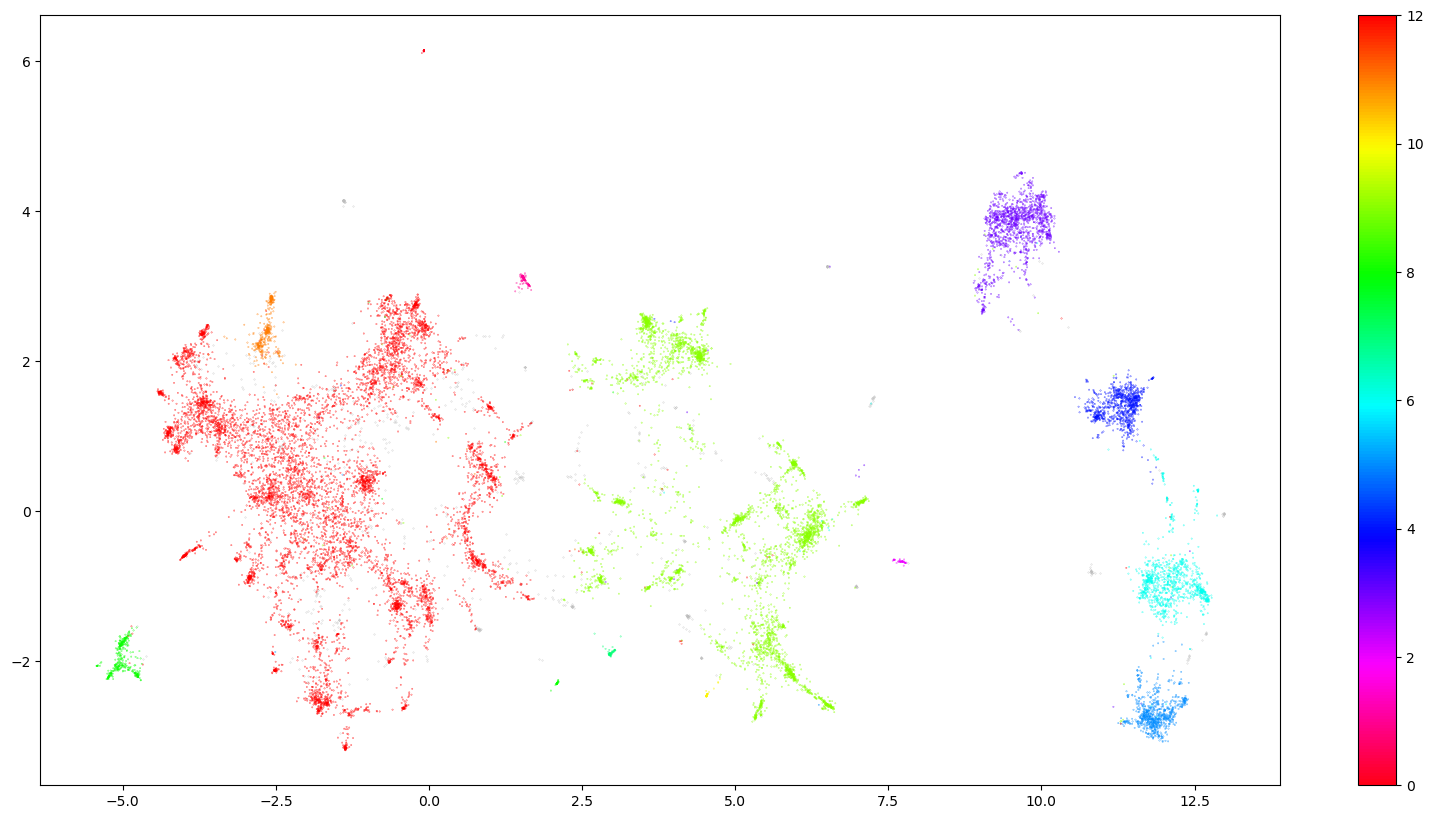

In [57]:
import matplotlib.pyplot as plt

# Prepare data
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()

In [107]:
changed_df["cluster"] = cluster.labels_

In [108]:
changed_df[changed_df.cluster == 31].sample(10)

,page_name,status,lines_added,lines_deleted,lines_changed,actions,wiki_features,ruwiki_features,parsing_time,location,categories_removed,categories_added,cluster,text_cluster
12780,"Терентьев, Александр Васильевич (депутат)",4,[],[],"[(Из-за вторжения России на Украину, находится...","{'change_Argument': 0, 'insert_Argument': 0, '...",{'categories': ['Депутаты Государственной думы...,{'categories': ['Депутаты Государственной думы...,2023-09-28 23:20:34.048317,Russia,"{Лица, подвергнутые санкциям в связи с конфлик...",{},31,"Page title: Терентьев, Александр Васильевич (д..."
7485,Министерство цифровой трансформации Украины,4,[],"[Точное количество опознанных не сообщается, о...",[(После идентификации трупов сотрудники минист...,"{'change_Argument': 0, 'insert_Argument': 0, '...","{'categories': ['Министерства Украины'], 'medi...","{'categories': ['Министерства Украины'], 'medi...",2023-09-28 22:17:51.122987,Ukraine,{},{},31,Page title: Министерство цифровой трансформаци...
16791,"Родригез, Тимур",4,[],"[Танцы», в котором Тимур стал постоянным члено...",[(Тиму́р Родри́гез (настоящее имя — Тиму́р Мих...,"{'change_Argument': 0, 'insert_Argument': 0, '...",{'categories': ['Выпускники Пензенского универ...,{'categories': ['Выпускники Пензенского универ...,2023-09-29 00:06:56.641272,Russia,"{Телеведущие СТС, Телеведущие телеканала «Пятн...",{},31,"Page title: Родригез, Тимур\nPage location: Ru..."
129,"Цаплиенко, Андрей Юрьевич",4,[],[],[(С начала вторжения России на Украину освещае...,"{'change_Argument': 0, 'insert_Argument': 0, '...",{'categories': ['Выпускники Харьковского инсти...,{'categories': ['Выпускники Харьковского инсти...,2023-09-28 20:59:20.195303,Ukraine,{},{},31,"Page title: Цаплиенко, Андрей Юрьевич\nPage lo..."
12052,"Богуславский, Константин Евгеньевич",4,[],[],[(Павловка Богодуховского уезда Харьковской гу...,"{'change_Argument': 0, 'insert_Argument': 0, '...","{'categories': ['Певцы и певицы СССР', 'Певцы ...","{'categories': ['Певцы и певицы СССР', 'Певцы ...",2023-09-28 23:11:34.923417,unknown,{},{},31,"Page title: Богуславский, Константин Евгеньеви..."
10520,Крепостная (телесериал),4,[],[],"[(20 июля 2022 года стало известно, что в связ...","{'change_Argument': 0, 'insert_Argument': 0, '...","{'categories': ['Телесериалы России', 'Телесер...","{'categories': ['Телесериалы России', 'Телесер...",2023-09-28 22:55:19.102287,Ukraine,{},{},31,Page title: Крепостная (телесериал)\nPage loca...
2305,Conflict Intelligence Team,4,[10 августа 2023 года решением Генеральной про...,[],[(С конца октября 2021 года расследователи CIT...,"{'change_Argument': 0, 'insert_Argument': 0, '...","{'categories': ['Гражданская журналистика', 'Н...","{'categories': ['Гражданская журналистика', 'Н...",2023-09-28 21:22:24.632414,unknown,{},{},31,Page title: Conflict Intelligence Team\nLines ...
16906,"Хайнс, Джим",4,[Умер 3 июня 2023 года в возрасте 76 лет],[],"[(10 сентября 1946, Думас, штат Арканзас, США)...","{'change_Argument': 0, 'insert_Argument': 0, '...",{'categories': ['Игроки в американский футбол ...,{'categories': ['Игроки в американский футбол ...,2023-09-29 00:08:47.148611,United States of America,{},{},31,"Page title: Хайнс, Джим\nPage location: United..."
7858,Пупко,4,[],[],"[(1945) — советская поэтесса и переводчица, ла...","{'change_Argument': 0, 'insert_Argument': 0, '...","{'categories': [], 'media': [], 'references': ...","{'categories': [], 'media': [], 'references': ...",2023-09-28 22:21:38.722701,unknown,{},{},31,Page title: Пупко\nLines changed (| separated ...
10692,Свен I Вилобородый,4,[],[],[(В историческом телесериале канала Netflix «В...,"{'change_Argument': 0, 'insert_Argument': 0, '...","{'categories': ['Родившиеся в 960-е годы', 'Пр...","{'categories': ['Родившиеся в 960-е годы', 'Пр...",2023-09-28 22:58:00.440043,Denmark,{},{},31,Page title: Свен I Вилобородый\nPage location:...


# Generating cluster vectors (few-shot classification): 

In [318]:
clusters = {
    "General neutral or unclassified updates": """
            Changes to individuals' biographical details, including birth and death years.
            Adjustments to an individual's artistic or professional achievements.
            Changes related to sport events. NO changes at all
            
            Examples separated by ^^^:
            
            Page title: Холлинс, Джон
            Page location: United Kingdom
            Lines changed (| separated pairs of text before and after): ('Джон Уи́льям Хо́ллинс (; родился 16 июля 1946 года, Гилдфорд, графство Суррей) — английский футболист и футбольный тренер', 'Джон Уи́льям Хо́ллинс (; родился 16 июля 1946 года, Гилдфорд, графство Суррей — 14 июня 2023) — английский футболист и футбольный тренер')
            Lines added (| separated): Умер 14 июня 2023 года в возрасте 76 лет
            Templates added (| separated):
            ^^^
            Page title: FinnMetko
            Lines added (| separated): 28 120|9 950|36 000|34 700
            ^^^
            Page title: Дискография Foo Fighters
            Lines added (| separated): But Here We Are|Звукозаписывающая компания: RCA, Roswell|Дата выхода: 2 июня 2023
            ^^^
            Page title: Sanofi
            Page location: France
            Lines added (| separated): «Туджео» является одним из востребованных в госсегменте препаратов: только за половину 2023 года объём его закупок превысил 3 млрд руб
            Templates added (| separated):
            ^^^
            Page title: G2 Esports
            Page location: Spain
            Lines added (| separated): IEM Cologne 2023|400 000 $|26 июля — 8 августа
            ^^^
            Page title: Морж
            Lines added (| separated): Черный колодец
            ^^^
            Page title: Своя игра
            Page location: Russia
            Lines changed (| separated pairs of text before and after): ('Выходит на НТВ по воскресеньям в 15:00', 'Выходит на НТВ по выходным в 15:00')
            ^^^
            Page title: Донузлав (балка)
            Page location: Russia_Ukraine
            Lines changed (| separated pairs of text before and after): ('Донузлав (также Донузлавская; , ) — маловодная (сток может наблюдаться во время весенних паводков и летне-осенних ливней) балка эрозионного происхождения в Раздольненском районе Крыма', 'Донузлав (также Донузлавская — маловодная (сток может наблюдаться во время весенних паводков и летне-осенних ливней) балка эрозионного происхождения в Раздольненском районе Крыма')
            """,
    
    "War denying cluster": """
    
        Changes that aim to delete all the mentions about the war including destructions, death, mentioning of word "war"
        Variations in wording and terminology reflecting different perspectives or nuances of the same event or action.

        But it is not about sanctions. 

        Good Examples separated by ^^^:

        Page title: Шпагин, Василий Никифорович
        Lines changed (| separated pairs of text before and after): ('Надгробный памятник уничтожен в результате бомбардировок Чернигова в марте 2022 года в ходе Вторжения России на Украину', 'Надгробный памятник уничтожен в результате бомбардировок Чернигова в марте 2022 года в ходе военных действий на Украине')
        ^^^
        Page title: Курганов, Алексей Сергеевич
        Lines changed (| separated pairs of text before and after): ('С 24 февраля 2022 года в составе своего подразделения принимал участие во вторжении России на Украину', 'С 24 февраля 2022 года в составе своего подразделения принимал участие в военных действиях на Украине')
        Categories removed (| separated): Погибшие в ходе военных действий на Украине (Россия)
        Categories added (| separated): Погибшие в ходе вторжения России на Украину (Россия)|Статьи с эдитнотисом об осторожности при редактировании
         ^^^
         Page title: Венецианская биеннале
        Page location: Italy
        Lines deleted (| separated): 2022 — выставка в павильоне не состоялась по причине Вторжения России на Украину
        ^^^
        Page title: Варшава
        Page location: Poland
        Lines changed (| separated pairs of text before and after): ('Варшава из-за вторжения России на Украину расторгла соглашения с российскими городами:', 'Варшава из-за военных действий на Украине расторгла соглашения с российскими городами:')
        ^^^
        Page title: Шляховская сельская община
        Page location: Ukraine
        Lines deleted (| separated): С февраля 2022 года населенные пункты общины находятся под контролем российских войск в ходе русско-украинской войны
    
        Now BAD examples: 
        Page title: Самокиш, Владимир Игоревич
        Page location: Russia
        Lines changed (| separated pairs of text before and after): ('Из-за вторжения России на Украину, находится под международными санкциями Евросоюза, США, Великобритании и ряда других стран', 'Находится в санкционном списке Евросоюза, США, Великобритании и ряда других стран')
        Categories added (| separated): Лица, подвергнутые санкциям в связи с конфликтом на Украине
        ^^^
        Page title: ЛОМО
        Page location: Russia
        Lines changed (| separated pairs of text before and after): ('24 февраля 2023 года, в годовщину начала российского вторжения на Украину, компания внесена в санкционный список Великобритании', '24 февраля 2023 года компания внесена в санкционный список Великобритании')
        Categories added (| separated): Компании, подвергнутые санкциям в связи с вторжением России на Украину
        ^^^
        Page title: M14 (винтовка)
        Page location: United States of America
        Lines changed (| separated pairs of text before and after): (': Во время вторжения России в Украину были поставлены в качестве военной помощи из США', ': В ходе военных действий на Украине были поставлены в качестве военной помощи из США')
    """,
    
    "Sanction related changes": """
        The addition or removal of sanctions-related information.

        Reflect international sanctions and their scope.

        Related to individuals facing sanctions in connection with the Ukraine conflict.

        Indicating sanctions imposed on entities due to the invasion.

        Content mentioning the impact of the invasion on specific businesses or organizations.
        
        Examples separated by ^^^:
        
        Page title: Самокиш, Владимир Игоревич
        Page location: Russia
        Lines changed (| separated pairs of text before and after): ('Из-за вторжения России на Украину, находится под международными санкциями Евросоюза, США, Великобритании и ряда других стран', 'Находится в санкционном списке Евросоюза, США, Великобритании и ряда других стран')
        Categories added (| separated): Лица, подвергнутые санкциям в связи с конфликтом на Украине
        ^^^
        Page title: ЛОМО
        Page location: Russia
        Lines changed (| separated pairs of text before and after): ('24 февраля 2023 года, в годовщину начала российского вторжения на Украину, компания внесена в санкционный список Великобритании', '24 февраля 2023 года компания внесена в санкционный список Великобритании')
        Categories added (| separated): Компании, подвергнутые санкциям в связи с вторжением России на Украину
        ^^^
        Page title: Федеральное дорожное агентство
        Page location: Russia
        Lines added (| separated): 14 сентября 2023 года был включён в санкционные списки США
        Templates added (| separated): 
        Categories removed (| separated): Росавтодор
        Categories added (| separated): Федеральные агентства Российской Федерации
    """,
    
    "Territorial Reassignments": """
        
        Changing political affiliation or territorial status of locations, reflecting changes in sovereignty between Ukraine and Russia.
        For example: Луганской области change to Луганской Народной Республики, Донецкая область -> Донецкая Народная Республика, Mentioning teritories from Луганской, Донецкая, Херсонская, Запорожская oblast and Crimea belong to Russia. 
        
        Examples separated by ^^^:
        Page title: Караяшник
        Lines changed (| separated pairs of text before and after): ('Караяшник — село в Старобельском районе Луганской области', 'Караяшник — село в Старобельском районе Луганской Народной Республики')
        ^^^
        Page title: Малая Каменка (приток Большой Каменки)
        Page location: Ukraine
        Lines changed (| separated pairs of text before and after): ('Малая Каменка — малая река в Луганской области', 'Малая Каменка — малая река в Луганской Народной Республике России')
        ^^^
        Page title: Лесное
        Lines changed (| separated pairs of text before and after): ('Лесное — посёлок городского типа в Макеевском городском совете', 'Лесное — посёлок городского типа в городском округе Макеевка')|('Луганская область', 'Луганская Народная Республика')|('Лесное — посёлок в Никольском районе', 'Лесное — посёлок в Володарском районе')|('Лесное — посёлок в Антрацитовском городском совете', 'Лесное — посёлок в Антрацитовском районе')
        Lines deleted (| separated): Донецкая область
        Lines added (| separated): Донецкая Народная Республика
        ^^^
        Page title: Пшеничное (Запорожская область)
        Page location: Ukraine
        Lines deleted (| separated): Запорожская область,|Токмакский район,|Пшеничное () — село,|Новенский сельский совет,|Код КОАТУУ — 2325282403
        Lines added (| separated): Пшеничное — село в Токмакском районе Запорожской области|Договор между Запорожской областью и Российской Федерацией от 30.09.2022 года определяет область, включая село Пшеничное, как новый субъект в составе Российской Федерации|Власти Украины это оспаривают, продолжая считать соответствующую область территорией Украины
        Templates added (| separated):
        ^^^
        Page title: Новая Кубань (Херсонская область)
        Page location: Ukraine
        Lines changed (| separated pairs of text before and after): ('Новая Кубань () — село в Великоалександровском районе Херсонской области Украины', 'Новая Кубань — село в Великоалександровском районе Херсонской области')|('74140, Херсонская обл', 'До 2022 года: 74140, Херсонская обл')
        Lines deleted (| separated): Новая Кубань на сайте Верховной рады Украины|Код КОАТУУ — 6520983701|Почтовый индекс — 74140|Телефонный код — 5532|Население по переписи 2001 года составляло 525 человек
        Lines added (| separated): Договор между Херсонской областью и Российской Федерацией от 30.09.2022 года определяет область, включая село Новая Кубань, как новый субъект в составе Российской Федерации|Власти Украины это оспаривают, продолжая считать соответствующую область территорией Украины
        Templates added (| separated):
        ^^^
        Page title: Збурьевский Кут
        Page location: Ukraine
        Lines changed (| separated pairs of text before and after): ('Збурьевский Кут или Збурьевский Лиман — озеро, залив в дельте Днепра, расположенное на территории Скадовского района (Херсонская область, Украина)', 'Збурьевский Кут или Збурьевский Лиман — озеро, залив в дельте Днепра, расположенное на территории Скадовского района Херсонской области России')

    """,
    "Deletion of Criticism or Opposition": """
    
        Deletion of references to criticism or opposition to Vladimir Putin's policies, specifically in Ukraine and Crimea.
        Removal of content related to individuals' support for or endorsement of Russian President Vladimir Putin.

        Removal of public comments or appearances related to the conflict.

        Edits involving the removal of content critical of individuals' actions or affiliations.
        Adjustments to career or collaboration details based on evolving geopolitical events.

        Notifications of websites being blocked or restricted in Russia.
        Notes on the continued accessibility of specific content or services despite blockades.

        Templates like "Иноагент" (foreign agent).

        Information about individuals' involvement in anti-war and anti-dictatorship activities.

        Information about support for political prisoners.

        Removal of information about individuals' public comments or appearances regarding the conflict.
        
        Examples separated by ^^^:
        Page title: Организация экономического сотрудничества и развития
        Page location: France
        Lines changed (| separated pairs of text before and after): ('Однако 13 марта 2014 года ОЭСР приостановила принятие России в члены на неопределённый срок из-за аннексии Крыма и войны на востоке Украины', 'Однако 13 марта 2014 года ОЭСР приостановила принятие России в члены на неопределённый срок из-за присоединения Крыма к РФ и войны в Донбассе')
        Lines deleted (| separated): ОЭСР в связи с вторжением России на Украину разрывает переговорный процесс о вступлении России в организацию
        ^^^
        Page title: Павел (Пономарёв)
        Page location: Kazakhstan
        Lines changed (| separated pairs of text before and after): ('Однако, получив информацию о последующих событиях в Белоруссии, принёс извинения за поздравление; после просмотра видео о задержании протестующих «он возмутился, ужаснулся и расстроился»', 'Однако, получив информацию о последующих событиях в Белоруссии, после просмотра видео о задержании протестующих «он возмутился, ужаснулся и расстроился»')
        Lines deleted (| separated): Да и вообще был не особо в чести у диктатора»
        ^^^
        Page title: Жуйков, Борис Леонидович
        Lines changed (| separated pairs of text before and after): ('В феврале 2022 подписал открытое письмо российских учёных и научных журналистов с осуждением вторжения России на Украину и призывом вывести российские войска с украинской территории', 'В феврале 2022 подписал открытое письмо российских учёных и научных журналистов с осуждением военных действий на Украине и призывом вывести российские войска с украинской территории')
        ^^^
        Page title: Военные преступления России
        Lines deleted (| separated): Военные преступления в период вторжения России на Украину|Когда в 2016 году Международный уголовный суд (МУС) приступил к расследованию аннексии Крыма Россией на предмет возможных нарушений международного права, Россия внезапно вышла из состава членов суда
        Lines added (| separated): 
        ^^^
        Page title: Галямина, Юлия Евгеньевна
        Page location: Russia
        Lines changed (| separated pairs of text before and after): ('Юлия была обвинена по «дадинской» статье 212.1 УК РФ', 'Юлия была обвинена по статье 212.1 УК РФ')
        Lines deleted (| separated): 
        Templates added (| separated): Иноагент
        
        
    """,
    "Sexual practices, gender-related concepts and LGBTQ+ Changes": """
        Deletion of specific historical information related to LGBTQ+ topics.
        Alterations in terminology related to sexual practices or gender-related concepts.
        
        Examples separated by ^^^:
        ^^^
        Page title: Город секса
        Page location: Spain
        Lines deleted (| separated): Private Gold 80 — Sex City 2 на сайте adultfilmdatabase|Private Gold 78 — Sex City на сайте adultfilmdatabase|Private Gold 82 — Sex City 3 на сайте adultfilmdatabase
        ^^^
        Page title: Раздвоенный пенис
        Lines added (| separated): 
        Templates added (| separated): 
        ^^^
        Page title: Сексуальные позиции
        Lines deleted (| separated): Гусарская — с закинутыми вверх ногами пассивного партнёра|Позы Аретино|На коленях|Позиция «сэндвич» (женщина между двумя мужчинами)|Сексуальные практики между мужчинами|Поза 69|Женщина сверху|Двойное проникновение|Сексуальные практики между женщинами|Мужчина (активный партнёр) сверху|На боку
        Templates added (| separated): 18+|Гендеры
        ^^^
        Page title: Терминология для обозначения гомосексуальности
        Lines deleted (| separated): Тем самым они подчёркивали то, что не только не испытывают стыд за себя, но и гордятся своей сексуальностью|Некоторые авторы включают в «нетрадиционную ориентацию» по аналогии с «сексуальными меньшинствами» также педофилию, садомазохизм и другие отличные от гетеронормативности модели поведения|Однако многие гомосексуалы не приемлют это слово|Однако чаще сексуальными меньшинствами обозначаются гомосексуальные и бисексуальные люди
        Lines added (| separated): Для обозначения людей различных сексуальных ориентаций, отличных от гетеросексуальности, часто используется собирательный термин «сексуальные меньшинства» (или, короче, «секс-меньшинства»)
        ^^^
        Page title: Радикальный феминизм
        Lines deleted (| separated): Радикальные феминистки утверждают, что эякуляция на лицо и анальный секс становятся всё более популярными среди мужчин в соответствии с трендами в порно
    """
}

In [319]:
from openai.embeddings_utils import cosine_similarity, get_embedding
from tqdm.auto import tqdm

labels = [f"Cluster name: ```{k}```, Description of main changes to include: ```{v}```" for k, v in tqdm(clusters.items())]

label_embeddings = [get_embedding(label, engine=embedding_model) for label in tqdm(labels)]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [320]:
transform_dict = {i: k for i, k in enumerate(clusters.keys())}

In [321]:
scores_all_2 = [[cosine_similarity(embeddings[j], label_embeddings[i]) 
               for i in range(len(clusters))] 
              for j in tqdm(range(len(embeddings)))]

  0%|          | 0/18520 [00:00<?, ?it/s]

In [322]:
scores_df_2 = pd.DataFrame(scores_all_2)
texts_df = pd.DataFrame({"texts": texts_to_embed, "clusters": cluster.labels_})

df_analytics = pd.concat([texts_df, scores_df_2], axis=1)
df_analytics["max_class"] = scores_df_2[[0,1,2,3,4,5]].T.idxmax()

In [327]:
for i in range(6):
    print(f"Cluster: {transform_dict[i]}")
    print()
    for t in df_analytics[df_analytics.max_class == i].sample(5).texts:
        print(t)
        print()
    print("_"*50)

Cluster: General neutral or unclassified updates

Page title: Вильберг, Айна Зиновьевна
Page location: Ukraine
Lines changed (| separated pairs of text before and after): ('Елена Белоус родилась в городе Каховка в Херсонской области Украины 10 января 1985 года', 'Елена Белоус родилась в городе Каховка в Херсонской области Украинской ССР 10 января 1985 года')|('В 2014 году коллектив собирался представить альбом под названием «Магия», однако по определённым причинам выход так и не состоялся', 'В 2014 году коллектив собирался представить альбом под названием «Магия», однако выход не состоялся')

Page title: Дэвидсон
Lines changed (| separated pairs of text before and after): ('1943) — австралийский теннисист и теннисный тренер', '1943—2023) — австралийский теннисист и теннисный тренер')

Page title: Харингтон, Кит
Page location: United Kingdom
Lines changed (| separated pairs of text before and after): ('В 2022 году актёр во время российского вторжения на Украину снялся в ролике в поддерж

In [326]:
df_analytics.max_class.map(transform_dict).value_counts()

max_class
Territorial Reassignments                                       9985
Deletion of Criticism or Opposition                             2574
General neutral or unclassified updates                         2403
Sanction related changes                                        2270
War denying cluster                                             1036
Sexual practices, gender-related concepts and LGBTQ+ Changes     252
Name: count, dtype: int64

In [10]:
all_df = pd.read_csv("clusters_notext_no_users.csv")
classes_df = pd.read_csv("ReveilRU taxonomy draft - NO text changes.csv")
classes_df.columns = ["cluster", "describtion", "rate", "name", "note"]
classes_df = pd.concat([classes_df, pd.DataFrame({"cluster": [-1], "name": ["Not classified"]})])
classes_dict = {k: v for k, v in zip(classes_df.cluster, classes_df.name)}

cluster_count = all_df.cluster.value_counts().reset_index()
cluster_count["name"] = cluster_count.cluster.map(classes_dict)

cluster_count.groupby("name")["count"].sum()

name
Deletion of Criticism or Opposition                                           215
Editnotice deletion                                                          3131
Language Variations                                                          2271
Not classified                                                               1487
Sanction related changes                                                       51
Sexual practices and education, gender-related concepts and LGBTQ+ Topics    2699
Territorial Reassignments                                                    3676
pharmaceutical legal notice                                                  1614
Name: count, dtype: int64

In [395]:
len(all_df) + len(df_analytics)

33664

In [ ]:
# Territorial Reassignments - 3676 + 9985 = 13661
# Deletion of Criticism or Opposition = 2574 + 215 = 2789
# Sanction related changes = 2270 + 51 = 2321
# Language Variations (War denying cluster) = 1036 + 2271 = 3307
# Sexual practices = 2699 + 252 = 2951
# Pharmaceutical legal notice = 1614
# Editnotice deletion = 3131
# General neutral or unclassified updates = 2403 + 1487 = 3890

# Corpus difference

In [1]:
%%time
import pandas as pd
import joblib

final_data = pd.DataFrame(joblib.load("../data/ru_wiki_final_dataset_v2.data"))

CPU times: user 17.1 s, sys: 2.75 s, total: 19.8 s
Wall time: 19.2 s


In [2]:
import shifterator as sh
from mwtokenizer.tokenizer import Tokenizer
from tqdm.auto import tqdm
from collections import Counter
from stop_words import get_stop_words
import re
import pymorphy2

stop_words = get_stop_words('ru')

def process_text(text, stop_words=stop_words):
    # Tokenize the text into words
    words = re.findall(r'\b\w+\b', text)
    # Remove stopwords
    stopwords = stop_words  # Add your list of Russian stopwords here
    cleaned_words = [word for word in words if word.lower() not in stopwords]
    return cleaned_words

all_pairs = []
for pair in tqdm(final_data.lines_changed.tolist()):
    all_pairs += pair
    
all_deleted = []
for pair in tqdm(final_data.lines_deleted.tolist()):
    all_deleted += pair
    
all_added = []
for pair in tqdm(final_data.lines_added.tolist()):
    all_added += pair

counter_wiki, counter_ruwiki = Counter(), Counter()

for t1, t2 in tqdm(all_pairs):
    counter_wiki.update(set([i for i in process_text(text=t1) if len(i) > 1]))
    counter_ruwiki.update(set([i for i in process_text(text=t2) if len(i) > 1]))

for t1 in tqdm(all_deleted):
    counter_wiki.update(set([i for i in process_text(text=t1) if len(i) > 1]))

for t2 in tqdm(all_added):
    counter_ruwiki.update(set([i for i in process_text(text=t2) if len(i) > 1]))

  0%|          | 0/35911 [00:00<?, ?it/s]

  0%|          | 0/35911 [00:00<?, ?it/s]

  0%|          | 0/35911 [00:00<?, ?it/s]

  0%|          | 0/39703 [00:00<?, ?it/s]

  0%|          | 0/82800 [00:00<?, ?it/s]

  0%|          | 0/45386 [00:00<?, ?it/s]

In [ ]:
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(10.5, 10.5)

proportion_shift = sh.ProportionShift(type2freq_1=counter_wiki,
                                      type2freq_2=counter_ruwiki)

proportion_shift.get_shift_graph(system_names = ['Russian Wikipedia', 'RWK'], height=10, dpi=500,
                                 top_n=40, text_size_inset=False, title = "    ",
                                 cumulative_inset=False, filename="plot_2.png", )